In [ ]:
import os
import sys
import numpy as np
from pathlib import Path
from keras import datasets
import matplotlib.pyplot as plt
from typing import Optional, Any

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import the module from the custom library
from src.models.data_loader import DataLoader
from src.architectures.sequential import Sequential
from src.models import TrainingArguments, LabeledData
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, activations, loss_functions, optimizers, callbacks

### Constants and hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'denoise_autoencoder')

In [3]:
n_samples = 1000 # Number of samples to generate
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split_pct = 0.2 # Percentage of samples to use for validation
learning_rate = 1e-03 # Learning rate for the optimizer
batch_size = 512 # Number of samples to use for each batch
epochs = 200 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility
data_noise = 0.15 # Noise to add to the data

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Add the channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Extract the number of classes in the dataset
num_classes = len(np.unique(train_labels))    

# Convert the lists to numpy arrays
X_train = Tensor(np.array(train_images))
y_train = Tensor(np.array(train_labels), dtype=np.int8)
X_test = Tensor(np.array(test_images))
y_test = Tensor(np.array(test_labels), dtype=np.int8)

# Split the training set into training, validation and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data(data=(X_train, y_train), split_pct=train_test_split_pct, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data(data=(X_train, y_train), split_pct=train_valid_split_pct, shuffle=True)[0]

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (38400, 28, 28, 1) (38400,)
Validation set: (9600, 28, 28, 1) (9600,)
Testing set: (12000, 28, 28, 1) (12000,)


### Data processing

In [6]:
# Normalization
def normalize(X: Tensor) -> Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [7]:
# Add noise to the input data
def add_noise(X: np.ndarray, noise: float) -> np.ndarray:
    """
    Add noise to the input data.
    
    Parameters:
    - X (np.ndarray): The input data to add noise to
    - noise (float): The noise to add to the input data

    Returns:
    - np.ndarray: The input data with noise added
    """
    
    # Add noise to the input data
    X_noisy = X + noise * np.random.normal(loc=0, scale=1.0, size=X.shape)
    
    # Clip the values to be between 0 and 1
    X_noisy = np.clip(X_noisy, 0., 1.)
    
    # Return the noisy input data
    return X_noisy


# Add noise to the input data
noise_factor = 0.6
X_train_noisy = Tensor(add_noise(X_train.data, noise_factor))
X_valid_noisy = Tensor(add_noise(X_valid.data, noise_factor))
X_test_noisy = Tensor(add_noise(X_test.data, noise_factor))

In [8]:
# Flatten the original input data
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_valid_flatten = X_valid.reshape((X_valid.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

# Flatten the noisy input data
X_train_noisy_flatten = X_train_noisy.reshape((X_train.shape[0], -1))
X_valid_noisy_flatten = X_valid_noisy.reshape((X_valid.shape[0], -1))
X_test_noisy_flatten = X_test_noisy.reshape((X_test.shape[0], -1))

### Data visualization

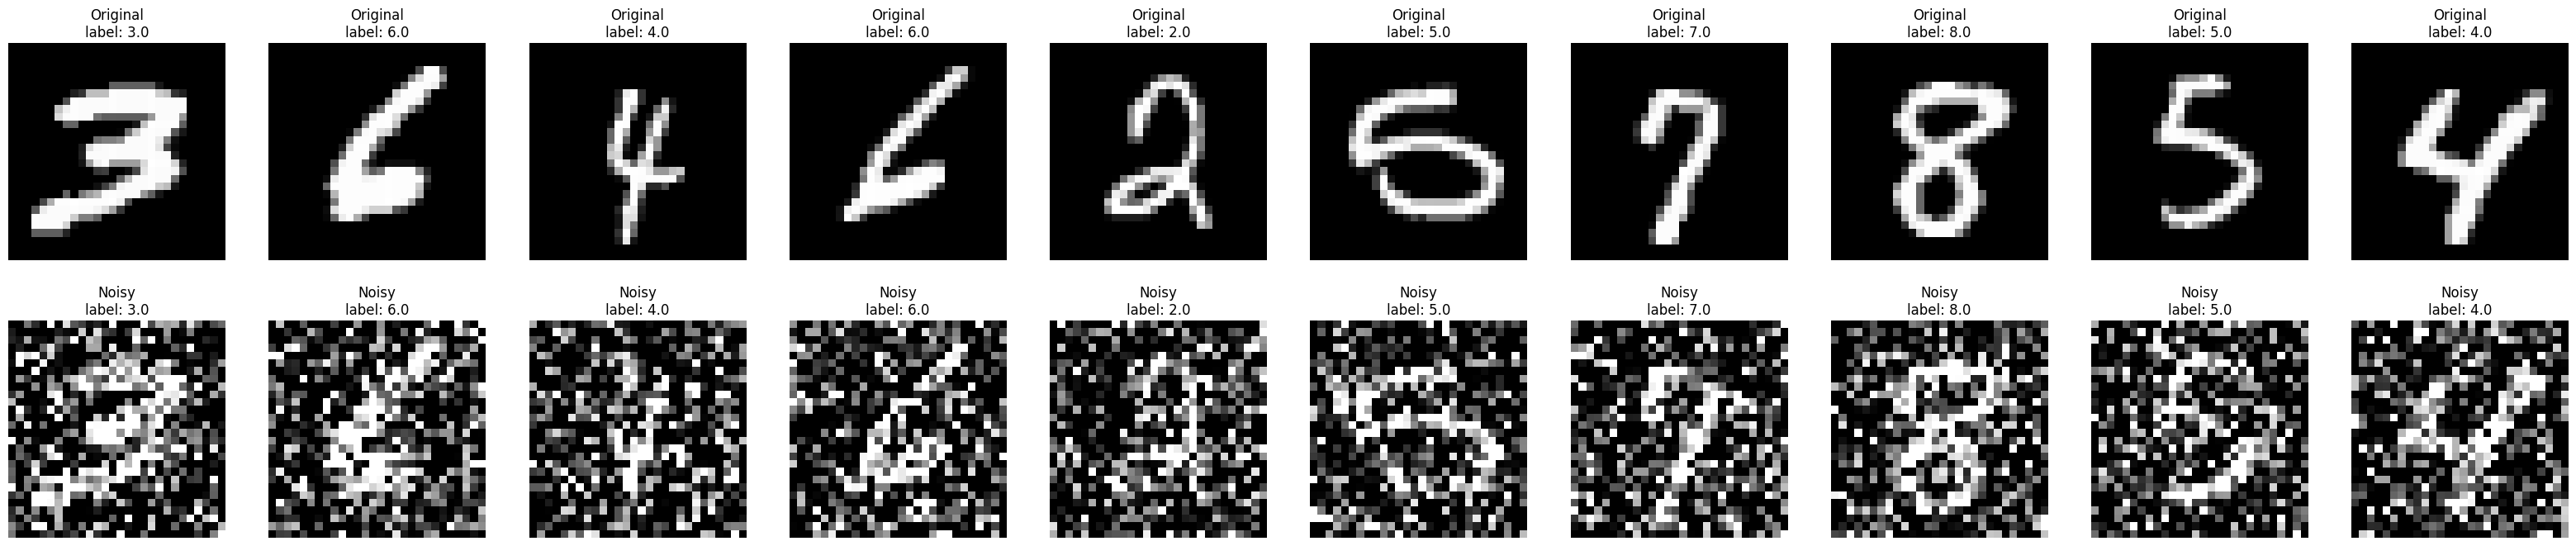

In [9]:
def plot_samples(originale_samples: list[np.ndarray], noisy_samples: Optional[list[np.ndarray]] = None, reconstructed_samples: Optional[list[np.ndarray]] = None, labels: Optional[list[np.ndarray]] = None) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - originale_samples (list[np.ndarray]): The original samples
    - noisy_samples (list[np.ndarray]): The noisy samples
    - reconstructed_samples (list[np.ndarray]): The reconstructed samples
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Build a list of image types to plot along with their titles.
    plot_info = [('Original', originale_samples)]
    if noisy_samples is not None:
        plot_info.append(('Noisy', noisy_samples))
    if reconstructed_samples is not None:
        plot_info.append(('Reconstructed', reconstructed_samples))
        
    # Get the number of rows and samples.
    n_rows = len(plot_info)
    n_samples = len(originale_samples)
    
    # Create a grid: columns = samples, rows = image types.
    _, axes = plt.subplots(n_rows, n_samples, figsize=(n_samples * 4, n_rows * 4))
    
    # Ensure axes is a 2D array.
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0) 
    if n_samples == 1:
        axes = np.expand_dims(axes, axis=1)
    
    def add_image(ax: Any, image: np.ndarray, title: str) -> None:
        """
        Add an image to a subplot.
        
        Parameters:
        - ax (Any): The subplot to add the image to
        - image (np.ndarray): The image to add to the subplot
        - title (str): The title of the subplot
        """
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(title)
    
    # Loop over rows (image types) and columns (samples).
    for i, (title_prefix, samples) in enumerate(plot_info):
        for j in range(n_samples):
            # Append the label text if provided.
            add_image(axes[i, j], samples[j], f"{title_prefix}\nlabel: {labels[j]}" if labels is not None else title_prefix)
        
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test.data[:10]),
    noisy_samples = list(X_test_noisy.data[:10]),
    labels = list(y_test.data[:10])
)

In [10]:
# Define the dimension of the latent space
latent_dim = 32

# Create the encoder
encoder = Sequential(
    name = 'Encoder',
    modules = [
        layers.Input(),
        layers.Dense(num_units=128, activation=activations.ReLU()),
        layers.Dense(num_units=64, activation=activations.ReLU()),
        layers.Dense(num_units=latent_dim, activation=activations.ReLU(), name='Latent'),
    ]
)

# Create the decoder
decoder = Sequential(
    name = 'Decoder',
    modules = [
        layers.Input(name='Latent'),
        layers.Dense(num_units=64, activation=activations.ReLU()),
        layers.Dense(num_units=128, activation=activations.ReLU()),
        layers.Dense(num_units=X_train_noisy_flatten.shape[1], activation=activations.Sigmoid())
    ]
)

# Create the auto-encoder
autoencoder = Sequential(
    name = 'Autoencoder',
    modules = [
        encoder,
        decoder
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate)

# Initialize the loss function
loss_fn = loss_functions.BinaryCrossEntropy()

### Initializing the model

In [11]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    autoencoder.eval()
    
    # Call the model with a batch of data to initialize it
    autoencoder(x=X_train_flatten[:batch_size])

In [12]:
# Display the encoder summary
encoder.modules.summary()

# Display the decoder summary
decoder.modules.summary()

# Display the model summary
autoencoder.modules.summary()


encoder.modules

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
module_list.0 (Input)                                  (512, 784)          0                   
-----------------------------------------------------------------------------------------------
module_list.1 (Dense)                                  (512, 128)          100480              
-----------------------------------------------------------------------------------------------
module_list.2 (Dense)                                  (512, 64)           8256                
-----------------------------------------------------------------------------------------------
module_list.3 (Dense)                                  (512, 32)           2080                
Total trainable parameters: 110816
-----------------------------------------------------------------------------------

### Training the model

In [ ]:
# Define the training arguments
train_arguments = TrainingArguments(
    data_loader = DataLoader(
        train_data = LabeledData(input={'x': X_train_noisy_flatten}, target=X_train_flatten),
        valid_data = LabeledData(input={'x': X_valid_noisy_flatten}, target=X_valid_flatten)
    ),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = epochs,
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Train the model
history = autoencoder.fit(train_arguments)

Epoch 1/200 --> loss: 0.35733 | val_loss: 0.26639                                                                                                    
Epoch 2/200 --> loss: 0.26421 | val_loss: 0.2628                                                                                                     
Epoch 3/200 --> loss: 0.25971 | val_loss: 0.25748                                                                                                    
Epoch 4/200 --> loss: 0.25462 | val_loss: 0.24798                                                                                                    
Epoch 5/200 --> loss: 0.24219 | val_loss: 0.23895                                                                                                    
Epoch 6/200 --> loss: 0.23701 | val_loss: 0.23555                                                                                                    
Epoch 7/200 --> loss: 0.23109 | val_loss: 0.22408                                                   

In [14]:
# Save the model
autoencoder.save(model_path)

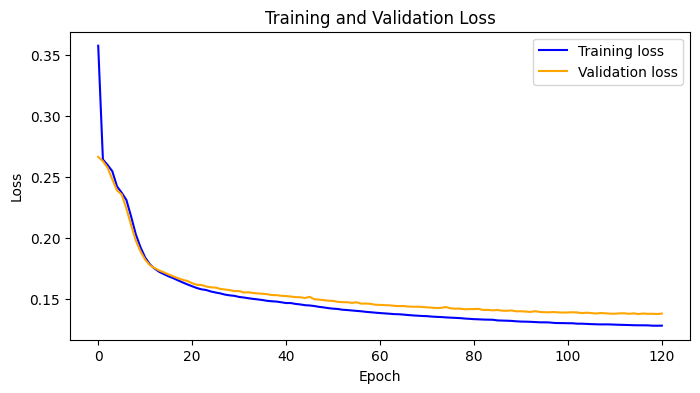

In [15]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Inference

In [16]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    autoencoder.eval()

    # Denoise the test set
    X_test_out = autoencoder(
        x = X_test_noisy_flatten,
        batch_size = batch_size
    )

# Reshape the denoised test set
X_test_denoised = X_test_out.output.reshape((-1, *X_test.shape[1:]))

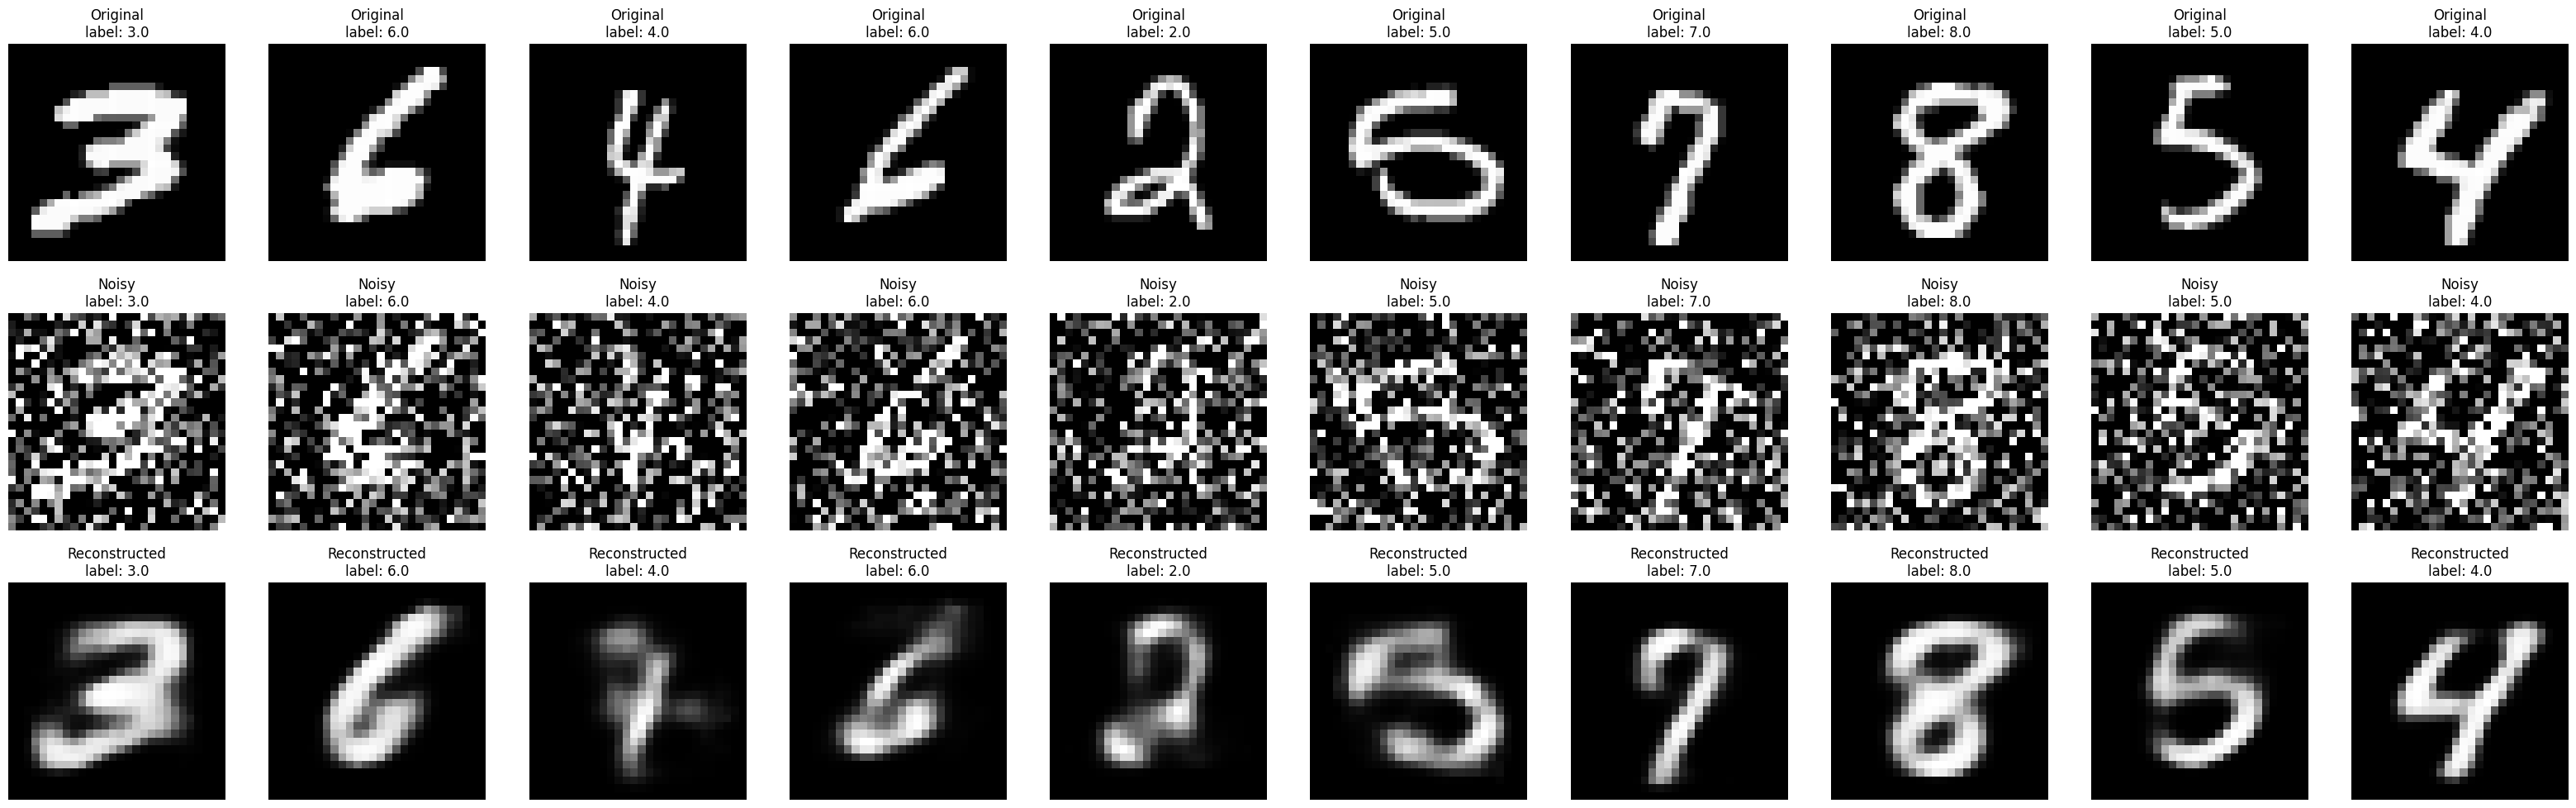

In [17]:
# Plot the first 10 samples
plot_samples(
    originale_samples = list(X_test.data[:10]),
    noisy_samples = list(X_test_noisy.data[:10]),
    reconstructed_samples = list(X_test_denoised.data[:10]),
    labels = list(y_test.data[:10])
)

### Generation

In [18]:
# Define the number of images to generate
n_images = 50

# Estimate the latent distribution from training samples
with context_manager.no_grad():
    encoder.eval()
    train_latent = encoder(x=X_train_flatten, batch_size=batch_size).output

# Compute the mean and standard deviation of the latent codes
latent_mean = train_latent.to_numpy().mean(axis=0)
latent_std = train_latent.to_numpy().std(axis=0) + 1e-6

# Sample latent codes from the empirical latent distribution
z = Tensor(
    latent_mean + np.random.randn(n_images, latent_dim) * latent_std,
    dtype = np.float32
)

In [19]:
# Decode sampled latent codes into image space
with context_manager.no_grad():
    # Set the decoder in evaluation mode
    decoder.eval()
    
    # Decode the sampled latent codes into image space
    generated_flat = decoder(x=z).output

# Reshape generated images to original image shape
generated_images = generated_flat.reshape((-1, *X_train.shape[1:]))

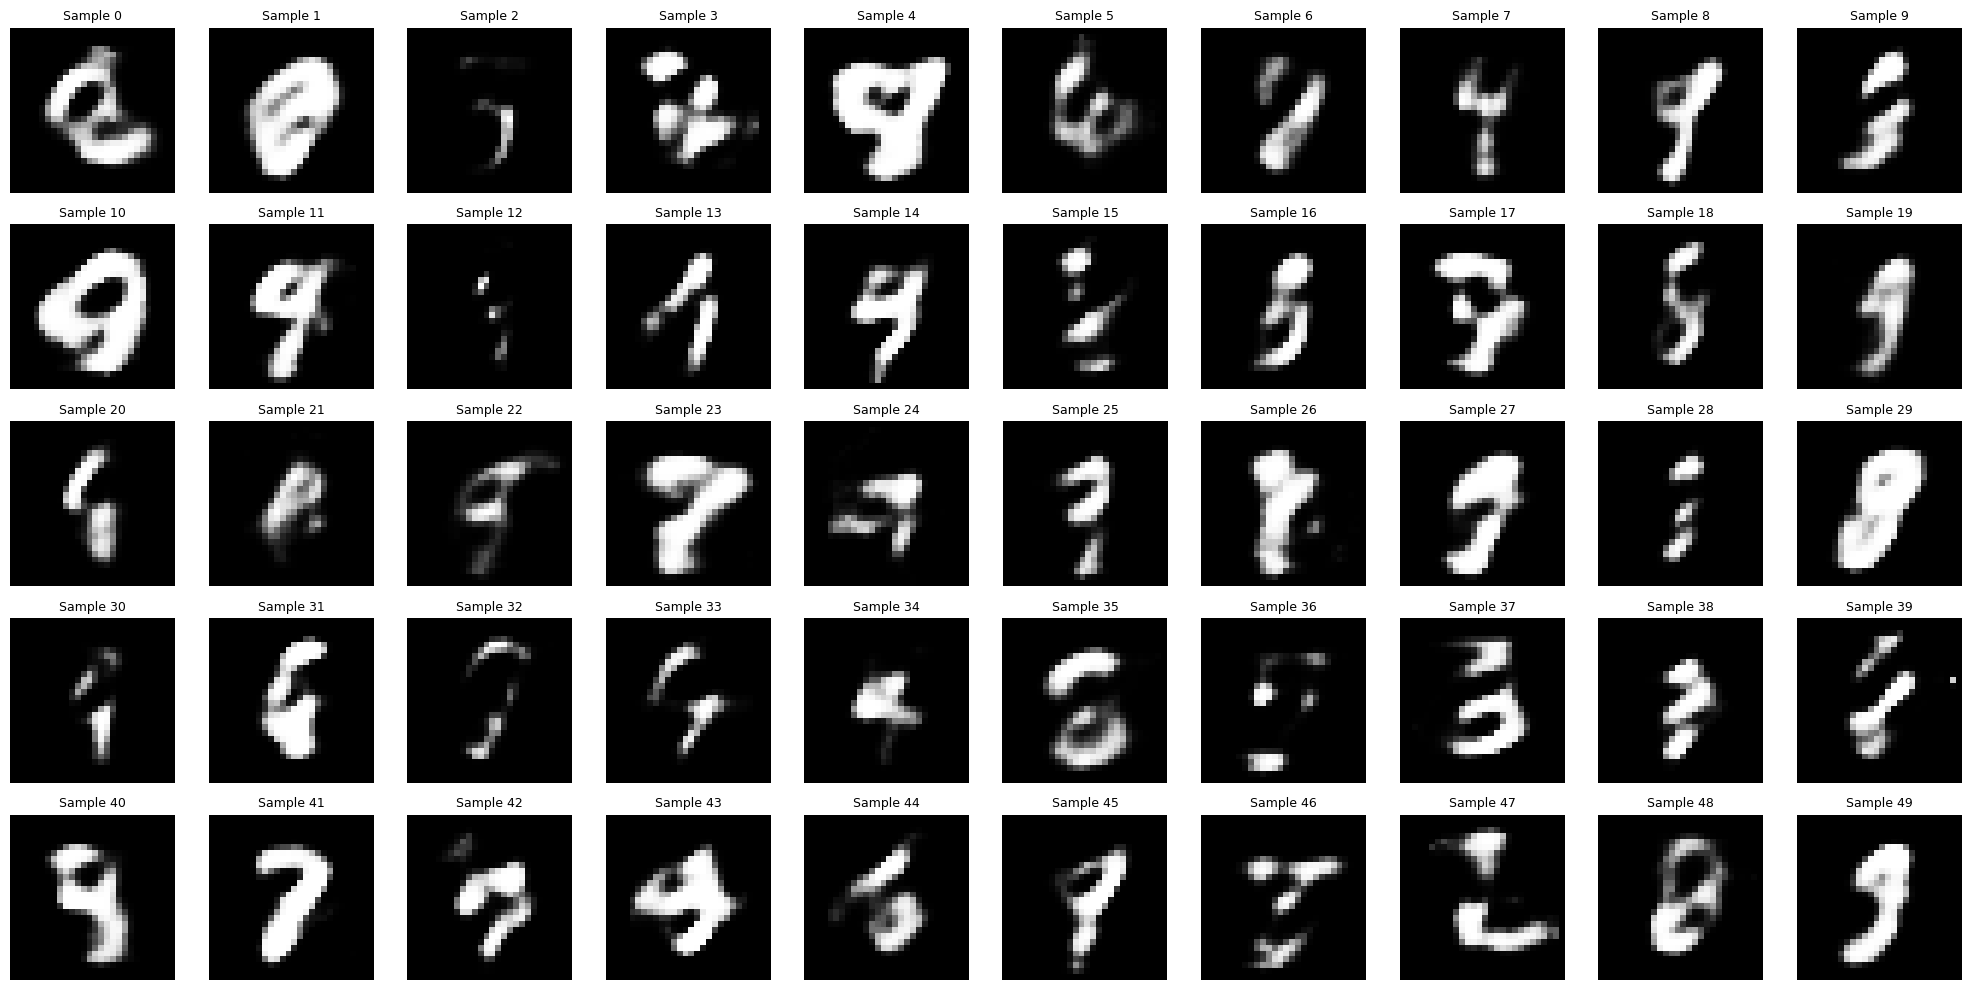

In [20]:
# Plot generated samples
n_cols = 10
n_rows = int(np.ceil(n_images / n_cols))

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

# Loop over the subplots and display the generated images
for idx in range(n_rows * n_cols):
    ax = axes[idx // n_cols, idx % n_cols]
    ax.axis('off')
    if idx < n_images:
        ax.imshow(generated_images.data[idx], cmap='gray')
        ax.set_title(f'Sample {idx}', fontsize=9)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()